In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/Datalogic/dl_coding_challange24_25.zip ./
!unzip dl_coding_challange24_25.zip

Mounted at /content/drive
Archive:  dl_coding_challange24_25.zip
   creating: dl_coding_challange24_25/
  inflating: dl_coding_challange24_25/0041_label.png  
  inflating: dl_coding_challange24_25/0001_label.png  
  inflating: dl_coding_challange24_25/0002_label.png  
  inflating: dl_coding_challange24_25/0003_label.png  
  inflating: dl_coding_challange24_25/0004_label.png  
  inflating: dl_coding_challange24_25/0005_label.png  
  inflating: dl_coding_challange24_25/0006_label.png  
  inflating: dl_coding_challange24_25/0007_label.png  
  inflating: dl_coding_challange24_25/0008_label.png  
  inflating: dl_coding_challange24_25/0009_label.png  
  inflating: dl_coding_challange24_25/0010_label.png  
  inflating: dl_coding_challange24_25/0011_label.png  
  inflating: dl_coding_challange24_25/0012_label.png  
  inflating: dl_coding_challange24_25/0013_label.png  
  inflating: dl_coding_challange24_25/0014_label.png  
  inflating: dl_coding_challange24_25/0015_label.png  
  inflating: dl_

In [88]:
import os
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

## 1. Segmentation

<i>`Otsu's method`</i> automatically finds the optimal thresholds by maximizing the between-class variance, eliminating the need for manual selection, which can be subjective and time-consuming.

<i>`Implementation`</i>: This variation extends the original Otsu's method for binary thresholding to identify multiple thresholds, suitable for segmenting images with more than two distinct intensity regions.

This implementation specifically finds thresholds for 3 levels, enabling the segmentation of images with a dark foreground, a light background (like a sticker), and a gray background (like cardboard).

It works well for images with well-separated intensity levels representing different objects or regions. For images with poor contrast or overlapping intensity distributions, the results might be less accurate.

In [ ]:
import numpy as np

def otsu_multi(image):
  """
  Calculates optimal thresholds for 3-level thresholding using Otsu's method.

  Args:
      image: A 2D grayscale image represented as a NumPy array.

  Returns:
      A tuple containing two integers: the first and second optimal thresholds.
  """
  blurred = cv2.GaussianBlur(image, (5, 5), 0)


  # Calculate the histogram
  histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

  # Total number of pixels
  N = np.sum(histogram)

  # Initialize variables
  optimal_thresh1 = 0
  optimal_thresh2 = 0
  max_between_var = 0

  # Mean of total intensity
  Mean_intensity = np.sum([i * histogram[i] for i in range(256)]) / N

  # Iterate over all possible threshold pairs
  for t1 in range(256):
      W0 = np.sum(histogram[:t1]) / N    # Weight of the first segment (from intensity 0 to t1)
      M0C = np.sum([i * histogram[i] for i in range(t1)]) / N  # Cumulative mean of the first segment
      if W0 == 0:
          continue
      M0 = M0C / W0  # Mean intensity of the first segment

      for t2 in range(t1 + 1, 256):
          W1 = np.sum(histogram[t1:t2]) / N   # Weight of the second segment (from intensity t1 to t2)
          M1C = np.sum([i * histogram[i] for i in range(t1, t2)]) / N  # Cumulative mean of the second segment
          if W1 == 0:
              continue
          M1 = M1C / W1  # Mean intensity of the second segment

          W2 = 1 - (W0 + W1)  # Weight of the third segment (from intensity t2 to 255)
          if W2 <= 0:
              break
          M2C = Mean_intensity - (M0C + M1C)  # Cumulative mean of the third segment
          M2 = M2C / W2  # Mean intensity of the third segment

          wcv = (W0 * (M0 - Mean_intensity) ** 2 +
                        W1 * (M1 - Mean_intensity) ** 2 +
                        W2 * (M2 - Mean_intensity) ** 2)  # within-class variance for the current pair of thresholds t1 and t2.

          if max_between_var < wcv:
              max_between_var = wcv
              optimal_thresh1 = t1
              optimal_thresh2 = t2

  return optimal_thresh1, optimal_thresh2



(1706, 2380)


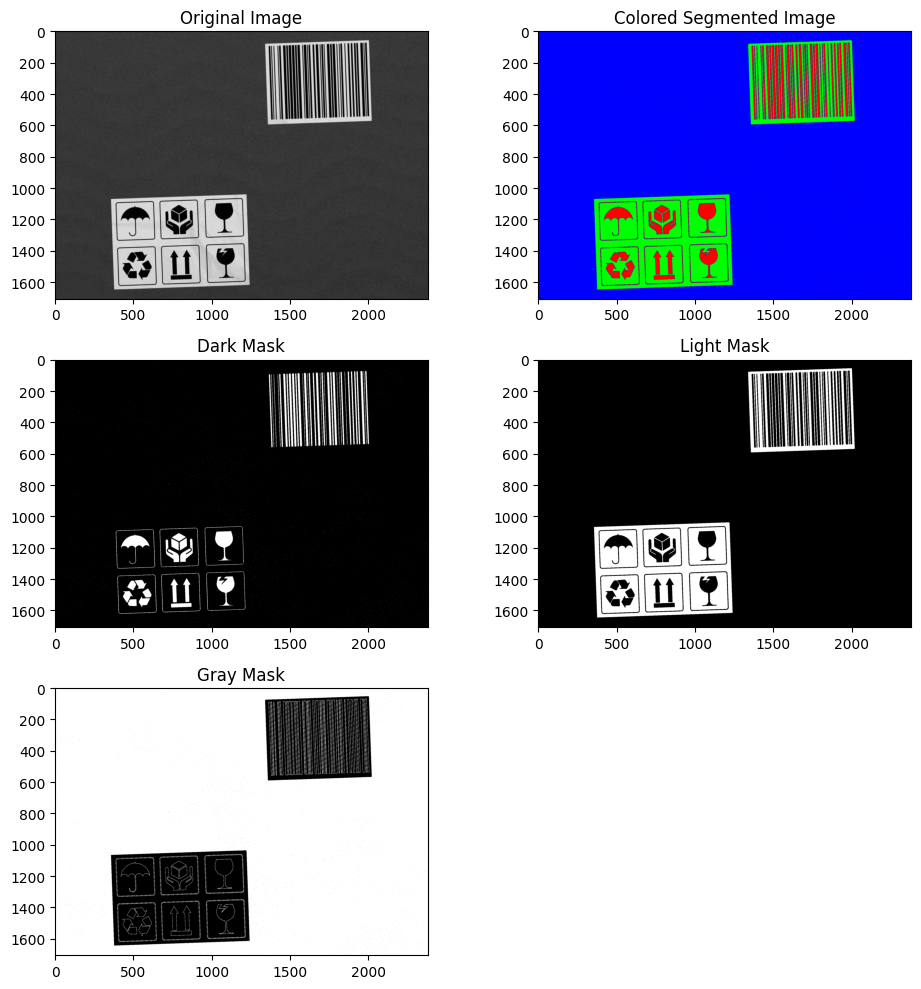

In [ ]:
import numpy as np
import cv2

def segment_image(image, threshold1, threshold2):
  """
  Segments an image into dark, light, and gray regions based on two thresholds.

  Args:
      image: A 2D grayscale image represented as a NumPy array.
      threshold1: The first optimal threshold.
      threshold2: The second optimal threshold.

  Returns:
      A dictionary containing five NumPy arrays representing the segmented regions:
          - image: The original image as a NumPy array
          - colored_segmented_image: A NumPy array of the colour segmented image
          - dark_mask: Binary mask for dark region (printed content)
          - light_mask: Binary mask for light region (sticker background)
          - gray_mask: Binary mask for gray region (cardboard background)
  """

  # Create empty masks for each region
  dark_mask = np.zeros_like(image, dtype=np.uint8)
  light_mask = np.zeros_like(image, dtype=np.uint8)
  gray_mask = np.zeros_like(image, dtype=np.uint8)

  # Dark Region: pixels less than or equal to threshold1
  dark_mask[image <= threshold1] = 255

  # Light Region: pixels between threshold1 and threshold2 (exclusive)
  gray_mask[(image > threshold1) & (image <= threshold2)] = 255

  # Gray Region: pixels above threshold2
  light_mask[image > threshold2] = 255

  colored_segmented_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
  colored_segmented_image[dark_mask == 255] = [255, 0, 0]  # Dark region (printed content) in Red
  colored_segmented_image[light_mask == 255] = [0, 255, 0]  # Light region (sticker background) in Green
  colored_segmented_image[gray_mask == 255] = [0, 0, 255]   # Gray region (cardboard background) in Blue

  return {'original': image, 'segmented': colored_segmented_image, 'dark': dark_mask, 'light':light_mask, 'gray':gray_mask}


image_path = 'dl_coding_challange24_25/0040_label.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)

# Example usage (assuming you have a grayscale image 'image' and thresholds from otsu_multi)
thresholds = otsu_multi(image)
threshold1, threshold2 = thresholds

segmented_image = segment_image(image, threshold1, threshold2)


plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.title('Original Image')
plt.imshow(segmented_image['original'], cmap='gray')

plt.subplot(3, 2, 2)
plt.title('Colored Segmented Image')
plt.imshow(segmented_image['segmented'])

plt.subplot(3, 2, 3)
plt.title('Dark Mask')
plt.imshow(segmented_image['dark'], cmap='gray')

plt.subplot(3, 2, 4)
plt.title('Light Mask')
plt.imshow(segmented_image['light'], cmap='gray')

plt.subplot(3, 2, 5)
plt.title('Gray Mask')
plt.imshow(segmented_image['gray'], cmap='gray')

plt.tight_layout()
plt.show()



In [ ]:
def process_folder(folder_path):
    """
    Processes the entire folder and segments all the images.

    Args:
        folder_path: Path to the folder of images

    Returns:
        A dictionary containing the NumPy arrays representing the image data:
    """
    segmented_images = {}
    # Loop through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                continue

            t1, t2 = otsu_multi(image)
            segmented_images[filename] = segment_image(image, t1, t2)

    return segmented_images

image_path= 'dl_coding_challange24_25/'
segmented_images= process_folder(image_path)


In [ ]:
for filename, image_data in segmented_images.items():

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title(f'Original Image {filename}')
    plt.imshow(image_data['original'], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(f'Colored Segmented Image {filename}')
    plt.imshow(image_data['segmented'])

    plt.tight_layout()
    plt.show()

## 2. Sticker Localization:

1. Contour Extraction: Contours are extracted from the mask image that represent the boundaries of objects in the image.

 Stickers often have a distinct boundary that can be captured as a contour. By finding contours in the light mask, the method identifies potential sticker regions.

2. Bounding Box Estimation: For each contour, a minimum area rectangle is fitted which represents the bounding box around the contour. It approximates the sticker shape with a rotated rectangle that encloses the contour with minimal area. This provides an orientation-aware bounding box for the sticker.

3. Filtering: Contours with areas below a certain threshold are filtered out to remove noise.

4. Visualization: Bounding boxes are drawn on the original image to visually represent the localization of stickers.

Note `(Bonus Challenge)` :
In this scenario with well-segmented stickers and consistent shapes, contour analysis can effectively localize them. The contour-based approach is computationally lighter.

However, factors like:

- Complex sticker shapes (beyond rectangles)
- Touching or overlapping stickers
- Imperfect segmentation

can lead to inaccurate bounding boxes or missed detections.

If sticker appearance variations or complex shapes are a concern, template matching (requires multiple reference templates) or machine learning (Support Vector Machines (SVMs) or Convolutional Neural Networks (CNNs)) can be explored (require extensive training data).

In [81]:
# Function to extract contours from dark mask image
def extract_contours(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def find_rotated_bounding_boxes(light_mask):
    # Find contours in the light mask
    contours= extract_contours(light_mask)

    bounding_boxes = []
    for contour in contours:
        # Filter out small contours to ignore noise
        if cv2.contourArea(contour) > 57000:  # Adjusted the area threshold as necessary
            # Finding the minimum area rectangle
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            bounding_boxes.append(box)

    return bounding_boxes

def draw_bounding_boxes(image, bounding_boxes):

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    img_copy = image.copy()
    # Draw the bounding boxes on the image
    for box in bounding_boxes:
        bb_image = cv2.drawContours(img_copy, [box], 0, (255, 255, 0), 15)  # Green color for bounding box
    return bb_image


<ipython-input-81-dc89470d12bb>:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


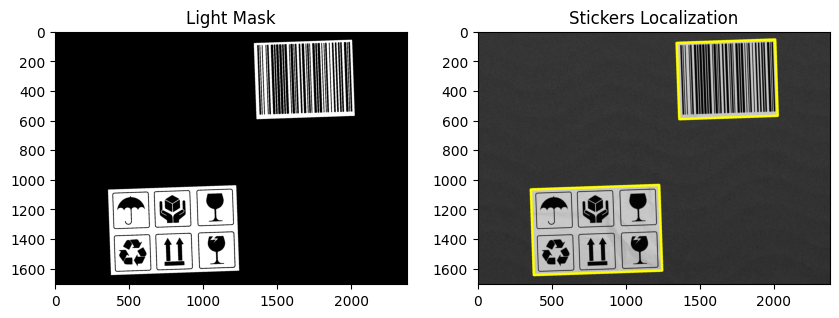

In [82]:
# Step 2: Find the rotated bounding boxes of the stickers
bounding_boxes = find_rotated_bounding_boxes(segmented_image['light'])

# Step 3: Draw bounding boxes on the image
output_image = draw_bounding_boxes(segmented_image['original'], bounding_boxes)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Light Mask')
plt.imshow(segmented_image['light'], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Stickers Localization')
plt.imshow(output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [83]:
def sticker_localization(segmented_images):
    """
    Localizing the stickers of all the images.

    Args:
        segmented_images: segmented image dictionary

    Returns:
        A dictionary with the localization data appended to the segmented images:
    """
    # Loop through all images in the folder
    for filename, images in segmented_images.items():
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            # Finding the rotated bounding boxes of the stickers
            bounding_boxes = find_rotated_bounding_boxes(images['light'])

            # Drawing bounding boxes on the image
            output_image = draw_bounding_boxes(images['original'], bounding_boxes)

            # Adding the output image to the same dictionary with a new key
            segmented_images[filename]['localized'] = output_image
            segmented_images[filename]['boxes'] = bounding_boxes

    return segmented_images

segmented_and_localized = sticker_localization(segmented_images)

<ipython-input-81-dc89470d12bb>:17: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


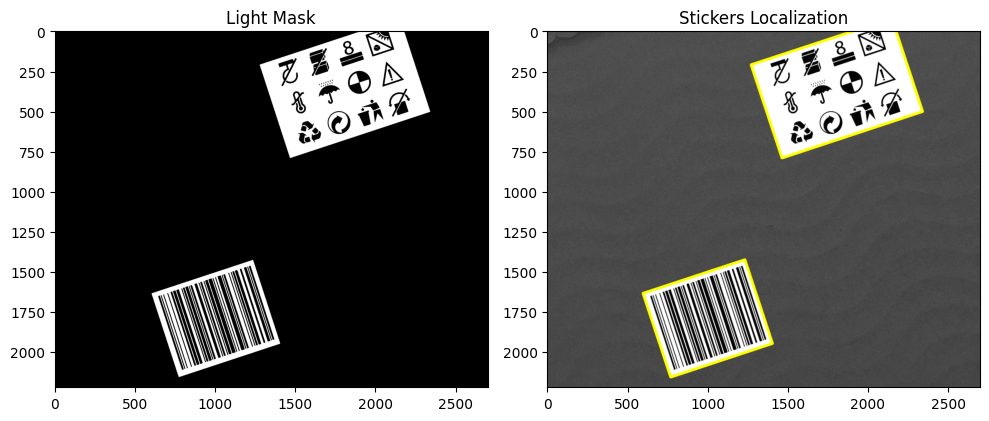

In [12]:
img= segmented_and_localized['0046_label.png']
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Light Mask')
plt.imshow(img['light'], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Stickers Localization')
plt.imshow(img['localized'])

plt.tight_layout()
plt.show()


In [ ]:
for filename, image_data in segmented_and_localized.items():
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title(f"Original {filename}")
    plt.imshow(image_data['original'])

    plt.subplot(1, 2, 2)
    plt.title(f'Stickers Localization {filename}')
    plt.imshow(image_data['localized'])

    plt.tight_layout()
    plt.show()

## Classification

### Feature Extraction

1. Input: The method takes a dark mask image (generated from segmentation) and a list of localized bounding boxes around potential stickers.
Sticker Extraction: It iterates through each bounding box and extracts the corresponding image patch from the mask.

2. Contour Finding: Within each patch, it finds contours. The assumption is that the largest contour represents the sticker's shape.

3. Hu Moment Calculation: For the largest contour, it calculates Hu Moments that capture the shape characteristics of a 2D object regardless of its size, orientation, and position.

(In this scenario the distinct and consistent shapes of the sticker help distinguish them from other image regions, which might not work for more colplex situations)

4. Output: The method returns three lists:
  - stickers: A list of image patches containing the extracted stickers.
  - features: A list of Hu Moment feature vectors, one for each sticker patch.
  - sticker_bboxes: A list of bounding box coordinates for each extracted sticker patch.

Note `(Bonus Challenge)` :  Hu Moments provide a compact representation of shape information in images, making them suitable for shape-based classification tasks.

Hu Moments are invariant to rotation, scale, and translation, making them robust to variations in sticker orientation and size.

For simple shapes, limited classes, feature extraction with Hu Moments might be sufficient.

Require exploring alternative methods like incorporating color/texture features, Histogram of Oriented Gradients (HOG), or deep learning for potentially better classification accuracy, especially if there are significant variations within sticker classes, complex shapes, many classes.

In [43]:
def extract_stickers_and_shape_features(mask_image, bounding_boxes):
    stickers = []
    features = []
    sticker_bboxes=[]
    for bbox in bounding_boxes:
        x1, y1 = bbox[0]
        x2, y2 = bbox[1]
        x3, y3 = bbox[2]
        x4, y4 = bbox[3]
        xmin = max(0, min(x1,x2,x3,x4))
        xmax= max(x1,x2,x3,x4)
        ymin= max(0, min(y1,y2,y3,y4))
        ymax= max(y1,y2,y3,y4)
        sticker = mask_image[ymin:ymax, xmin:xmax]
        stickers.append(sticker)
        sticker_bboxes.append((xmin, ymin, xmax, ymax))  # Store bounding box coordinates

        # Find contours
        contours, _ = cv2.findContours(sticker, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            # Assume the largest contour corresponds to the sticker
            largest_contour = max(contours, key=cv2.contourArea)

            # Compute Hu Moments
            moments = cv2.moments(largest_contour)
            hu_moments = cv2.HuMoments(moments).flatten()
            features.append(hu_moments)

    return stickers, features, sticker_bboxes


[(598, 1426, 1406, 2159), (1272, 0, 2342, 792)]

Applying the KMeans clustering algorithm to cluster the stickers into two classes (clusters): class barcode or class shipping symbols.

The algorithm effectively separates the stickers into two classes based on their extracted features.

The assumption here is that stickers belonging to the same class will have similar features and thus will be grouped together by the clustering algorithm.

The stickers in the cluster labeled as 0 are classified as "Barcode" stickers, while stickers in the cluster labeled as 1 are classified as "Shipping Symbols" stickers.

Note `(Bonus Challenge)`:

K-Means is generally more effective with a smaller number of well-separated classes. With only two sticker types (barcodes and shipping stickers), K-Means has a better chance of achieving accurate classification based on shape features.

The method is computationally efficient, especially for simple classification tasks like distinguishing between two classes of stickers.

It is suitable for applications where computational resources or labeled data are limited.

Since the stickers are classified based on their extracted features, the results are interpretable. It's easy to understand why a sticker is classified as belonging to a particular class based on its shape and other features.

Exploring methods like SVMs or CNNs could be beneficial for images with more than two stickers

In [75]:
def classification(segmented_and_localized):
    all_features, rois = [],[]
    # Iterating over each image in segmented_and_localized
    for filename, image_data in segmented_and_localized.items():
        # Extracting bounding boxes and features for the current image
        bounding_boxes = image_data['boxes']
        stickers, features, sticker_boxes = extract_stickers_and_shape_features(image_data['dark'], bounding_boxes)
        all_features.append(features)
        rois.append((stickers, sticker_boxes, image_data['original'], filename))

    all_features_flattened = np.vstack(all_features)

    # Fitting KMeans clustering model
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(all_features_flattened)
    all_labels_flattened = kmeans.labels_

    # Splitting the labels back into their respective images
    all_labels = []
    start_idx = 0
    for features in all_features:
        end_idx = start_idx + len(features)
        all_labels.append(all_labels_flattened[start_idx:end_idx])
        start_idx = end_idx

    barcode_cluster = 0
    shipping_sticker_cluster = 1

    # For generating the accurate labels and bounding the stickers with boxes
    for (sticker, sticker_box, image, filename), labels in zip(rois,all_labels):
      for i, label in enumerate(labels):
          if label == barcode_cluster:
              barcode_stickers= sticker_box[i]
          else:
              shipping_stickers= sticker_box[i]

      labeled_image, labeled_data = label_images(sticker_box, image, labels, filename)
      segmented_and_localized[filename]['labeled_image'] = labeled_image
      segmented_and_localized[filename]['labels'] = labeled_data

    return segmented_and_localized

    # Draw bounding boxes on the original image
def label_images(sticker_box, image, labels, filename):
    """
    Segments an image into dark, light, and gray regions based on two thresholds.

    Args:
        sticker_box: the bounding box vertices from light mask
        image: The original 2D grayscale image represented as a NumPy array.
        labels: The labes generated by kmean for the image.
        filename: The image name.

    Returns:
        A image and labeled data:
            - original_image: The labeled image as a NumPy array
            - labeled_data: A list with the label and its bounding box

    """
    h, w = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    original_image = image.copy()
    labeled_data= []

    for (bbox, label) in zip(sticker_box, labels):

        color = (0, 255, 0) if label == 0 else (0, 0, 255)  # to assign different colors to the bounding boxes for differt sticker class
        label_text = 'Barcode' if label == 0 else 'Shipping Symbols'  # assigning the class name to the label

        combined_label = f"{label_text}: {bbox}"
        labeled_data.append(combined_label)

        cv2.rectangle(original_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 5) # drawing bounding box on sticker

        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]  # for positioning the text label based on bbox position
        text_x = bbox[0]
        text_y = bbox[1] - 10 if bbox[1] - 10 > text_size[1] else bbox[3] + text_size[1] + 10
        if text_y + text_size[1] > h:
            text_y = h - 10
        if text_x + text_size[0] > w:
            text_x = w - text_size[0] - 10

        cv2.putText(original_image, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2) # labing the box with the target label

    return original_image, labeled_data



In [ ]:
labeled_images_dic = classification(segmented_and_localized)
for filename, image_data in labeled_images_dic.items():
    # Display the original image with bounding boxes
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title(f"Original {filename}")
    plt.imshow(image_data['original'], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(f'Labeled {filename}')
    plt.imshow(image_data['labeled_image'])

    plt.tight_layout()
    plt.show()

In [80]:
# Saving the final labels to a JSON file
annotations = [{'image': key, 'labels': value['labels'] } for key, value in labeled_images_dic.items()]

json_file_path = 'labeled_images.json'
with open(json_file_path, 'w') as json_file:
    json.dump(annotations, json_file, indent=4)

print(f"JSON file saved at: {json_file_path}")

JSON file saved at: labeled_images.json
